In [1]:
import gym
env = gym.make('Pong-v0')

In [50]:
import torch, scipy, scipy.misc
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt
import cv2

# Testing image stuff

In [47]:
def prepro(o,image_size=[80,80]):
    """    
    Input: 
    RGB image: np.array
        RGB screen of game, shape: (210, 160, 3)
    Default return: np.array 
        Grayscale image, shape: (80, 80, 1)
    
    """
    y = o.astype(np.uint8)
    resized = scipy.misc.imresize(y, image_size) # (80,80,3)
    # return np.expand_dims(resized.astype(np.float32),axis=2)
    return resized

In [8]:
env.reset().shape

(210, 160, 3)

In [279]:
data = env.reset()

In [285]:
data = 0.2126 * data[:, :, 0] + 0.7152 * data[:, :, 1] + 0.0722 * data[:, :, 2]
resized = cv2.resize(data, dsize=(80, 80), interpolation=cv2.INTER_CUBIC)
print(resized.shape)
resized = np.expand_dims(resized,axis=0)
print(resized.shape)

(80, 80)
(1, 80, 80)


In [281]:
resized.shape

(80, 80, 1)

In [284]:
for i in range(5):
    data, _, _, _ = env.step(3)

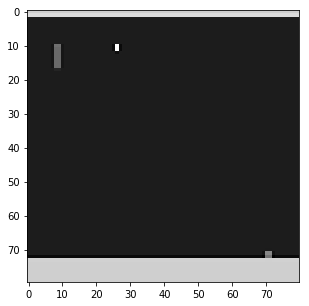

In [266]:
# data = env.reset()
# data = prepro(data)
data = 0.2126 * data[:, :, 0] + 0.7152 * data[:, :, 1] + 0.0722 * data[:, :, 2]
data = data[30:,:]
resized = cv2.resize(data, dsize=(80, 80), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(5,5))
plt.imshow(resized, interpolation='nearest')
plt.show()

In [294]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)

In [295]:
img = Variable(torch.Tensor(np.expand_dims(resized,axis=0)))

In [296]:
x = conv1(img)
print(x.shape)
y = conv2(x)
print(y.shape)

torch.Size([1, 16, 78, 78])
torch.Size([1, 32, 76, 76])


# Testing policy

In [9]:
class Policy(torch.nn.Module):
    def __init__(self):
        super(Policy, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3) # (batch_size, 16, 208, 158)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) # (batch_size, 32, 206, 156)
        self.fc1 = torch.nn.Linear(206 * 156 * 32, 256)
        self.fc2 = torch.nn.Linear(256, 6) # 6 actions to choose from
        self.logsoftmax = torch.nn.LogSoftmax(dim=1)
        
        self.episode_reward = 0
        
    def forward(self, x): # x: np.array (batch_size, 210, 160, 3)
        x = x.reshape(-1,3,210,160) # (batch_size, 3, 210, 160) Conv2d needs channel dim in front
        x = Variable(torch.Tensor(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 32*206*156)
        x = self.fc1(x) # TODO: add batch norm?
        x = self.fc2(x)
        output = self.logsoftmax(x) # this is log(p), need to take derivative of this wrt params
        return output # (batch_size, 6)

In [13]:
import time

policy = Policy()
policy.train()
optimizer = torch.optim.Adam(policy.parameters())
for i_episode in range(20):
    observation = env.reset()
    optimizer.zero_grad()
    policy.episode_reward = 0
     
    for t in range(100):
        # self.env.env.render()
        policy_output = policy(observation) # (batch_size, 6)
        action = int(torch.max(policy_output, dim=1)[1].data) # torch.max returns (max val, argmax)
        observation, reward, done, info = env.step(action)
        policy.episode_reward += reward
        # print('[Time step {}] Finished step, about to backprop'.format(t))
        policy_output[:,action].backward(retain_graph=False) # NOTE: only tried this with batch_size=1
                                            #if batch_size > 1, not sure if we need to manually average gradients
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    if not done:
        print('Force terminated episode after running for 100 steps')
    print('[After {} seconds] Reward is {}'.format(time.time()-a, policy.episode_reward))
    
    for param in policy.parameters():
        param.grad *= policy.episode_reward
    optimizer.step()

KeyboardInterrupt: 

In [5]:
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
fc1 = torch.nn.Linear(206 * 156 * 32, 512)
fc2 = torch.nn.Linear(512,6)
logsoftmax = torch.nn.LogSoftmax(dim=1)

In [6]:
img = Variable(torch.Tensor(a.reshape(1,3,210,160)))

In [7]:
x = conv1(img)
print(x.shape)
y = conv2(x)
print(y.shape)
y = y.view(-1, 32*206*156)
z = fc1(y)
z = fc2(z)
output = logsoftmax(z)

torch.Size([1, 16, 208, 158])
torch.Size([1, 32, 206, 156])


In [8]:
z

Variable containing:
  8.2107   4.8800  -6.4096  -6.6704  13.4930   6.7540
[torch.FloatTensor of size 1x6]

In [10]:
action = int(torch.max(z, dim=1)[1].data)

In [116]:
z[:,action].backward()

In [118]:
z

Variable containing:

Columns 0 to 7 
-21.8379   5.7717  -5.9310  19.1889   8.3340  33.8346   2.1224  19.7966

Columns 8 to 15 
 14.3258 -46.1118  16.0139   5.6273 -13.8274   5.9326   1.6676 -19.8407

Columns 16 to 23 
-27.6719 -39.0822  13.9200 -22.0696  -6.5525  13.1250 -28.6126 -10.2397

Columns 24 to 31 
 11.4150  13.4097  28.4361 -31.5592  -4.2237 -55.0887  16.1179 -29.0268

Columns 32 to 39 
-35.1181  25.2986   5.6320 -11.1191   2.6955   4.3656  -8.6665   3.8037

Columns 40 to 47 
 17.0454  63.1836  31.0468 -13.9832 -18.1233  14.8643  -0.6245  31.2789

Columns 48 to 55 
 18.5735  -3.0820  -4.7338  -3.9332  -9.8126   2.6434 -31.5285  -2.9424

Columns 56 to 63 
  0.5116   5.0216 -25.2562  19.2960  28.7456   1.1983  -2.7695 -13.7059

Columns 64 to 71 
 -9.3781  -9.7354  26.3769  -4.5851 -22.7312  19.2095 -29.6818  10.2846

Columns 72 to 79 
 -0.3456 -36.2800  31.0172  -1.2440  -4.8356 -20.5486 -11.0203  42.2295

Columns 80 to 87 
  1.2154 -38.9901 -12.1746   1.3580   5.1829   6.4726